# Unit Wins Above Average Metric for NFL Football and Proposing a Methodology  Individual WAA 

## 1. Introduction

The NFL has long lacked a quantifiable single metric for the importance of an individual player to a team. Other sports have largely well-defined Wins Above Replacement (WAR) formulas or models that quantify the value added by any given player compared to a "replacement" player. Baseball's WAR is generally considered to be a reliable metric for a player's value added, yet there is no current widely accepted similar metric for NFL football (PFF WAR grades are largely not publicly available). 

Baseball has an advantage over football in terms of its ability for individual player quality and value to be quantified. The nature of baseball is more one-on-one matchup based. Batter success corresponds directly to pitcher failure, and vice versa. Football is a highly team-dependent game, where players have different roles and responsibilities that can change play to play. A linebacker may be asked to cover a zone on one play, rush the passer the next, fit the run after that, or even have to decide between all three depending on his reads on the offense. And often, common metrics like passing yard by the Quarterback can be highly dependent on the quality of the team around him. 

In this analysis, I seek to describe a methodology to first calculate a Unit Wins Above Average, and extrapolate those results to an individual Wins Above Average metric.

## 2. Methodology
### 2.1 Adjusted Wins
To asses the quality and importance of a player, we must first understand the quality of his team. Instead of utilizing win-loss record which can be relatively fluky (see Minnesota Vikings 2022), I use adjusted wins, where 1 win is assigned when a team wins by greater than or equal to  10 points (Touchdown + Field Goal), 0.66 wins when between 7-9 points (Touchdown), 0.25 when between 4-6 points (1 Field Goal < x <= 2 Field Goals), and 0 points between 0-3, with corresponding negative values for the losing team. In this way, we achieve a much more accurate picture of the quality of the team as opposed to simple win-loss record. 
Whereas the 2022 Vikings would receive a 9.0 wins for a 13-4 record without adjustment, they receive 1.14 adjusted wins, equivalent to about a 9-8 record. 

In [ ]:
def adjustedWin(scoreDif):
    if scoreDif >=10: #10+:
        return 1
    elif scoreDif>=7: #7-9:
        return 0.66
    elif scoreDif>3: #4-6:
        return 0.25
    elif scoreDif>=-3: #(-3)-3:
        return 0
    elif scoreDif>-7: #(-6)-(-4)
        return -0.25
    elif scoreDif>-10: #(-9)-(-7)
        return -0.66
    else: #-10+
        return -1

### 2.2 PFF Grades

Pro Football Focus (PFF) is a sports analytics company that provides data, analysis, and video services to all 32 NFL teams and most College Football teams. One of their more public-facing data points is their PFF Player Grad. According to PFF, grades are calculated by assigning a score between -2 and +2 in increments of 0.5 for each player on every play. In theory, these grades are individualized and independent from other factors, and are intended to represent how well a player performed in any given play, game, or season. Traditional counting stats such as passing yards or sacks may be able to represent a broader view of the quality of a player, but they do not capture, for example, if they offensive line allowed many pressures, or if wide receivers weren't able to create separation consistently, or if the offensive scheme was faulty. So, PFF Grades are intended to compare a player's performance over (or under) expectectation on any given play. The Quarterback shouldn't be graded negatively because his offensive line neglected to block a defender, but he should be graded positively if he is able to complete a big time throw. Because of their individual and independent nature, I chose PFF Grades as the variable of interest in this analysis.

PFF may change the way they grade from season to season, so it was necessary to discriminate by season in order to account for differences in the grading system. Furthermore, different positions that play similar roles, such as Offensive Tackle and Offensive Guard may be graded in slightly different ways. Therefore, it was necessary to distinguish by position. Additionally, since different positions play several different roles (linebackers are responsible for pass coverage, pass rushing, and run defense), I sampled PFF Grades from different areas of play (category grades) for each position. 

Whereas other sports use WAR, it can be difficult to define a replacement player in the NFL. Therefore, I decided to measure an "average" player, by normalizing each positional category grade, grouping by year. This way, a player whose grade in any given category is 0 after normalization represents the "average" player. This grade, however, represents the average player who started a game, meaning there is some selection bias. One can interpret a 0 grade then, as an average starting player.

### 2.3 The Data

The target variable is adjusted wins for a team during a season. This is calculated by applying the adjustedWin function for each team's point differential by game in a season.

The predictor variables are positional category grades across a full season. I decided to exclude certain grades for categories of roles that certain positions tended not to perform. Notably, Wide Receiver (WR) rushing, Running Back (RB) run blocking, were excluded, and Cornerback (CB) pass rushing and Safety (S) pass rushing were combined as Defensive Back (DB) pass rushing. Although WRs do run the ball and RBs may run block, there were not enough plays in which this occured for each team to capture a consistent grade for every team. 

The data spans 7 seasons (2016-2022), excluding playoffs and preseason. If you are accessing this analysis from a public link, I have not made the data available, because PFF grades are a proprietary, paid-for service, of which I do not have permission to make available publicly. The code for formatting the data is available below, should you have access to the data I collected or decided to collect your own data. 

In [4]:
#imports
from copy import deepcopy
import matplotlib.pyplot as plt
import matplotlib.axes
import numpy as np
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [ ]:
#available at https://www.kaggle.com/datasets/tobycrabtree/nfl-scores-and-betting-data
df = pd.read_csv('spreadspoke_scores.csv')

In [ ]:
season_df = df[df['schedule_season'] == 2022] #select by season
season_df = a_df[a_df['schedule_playoff'] == False]
season_df

Initialize scores dataframe. The result of this dataframe is where the column sums are equal to the adjusted wins by team for that season

In [ ]:
scores_df = pd.DataFrame() 
for i ,r in a_df.iterrows():
    team_home = r['team_home']
    team_away= r['team_away']
    score_home=r['score_home']
    score_away=r['score_away']
    scores_df.loc[team_home,team_home] = 0
    scores_df.loc[team_away,team_away]=0

    if team_home in scores_df.index and team_away in scores_df.columns:
        if pd.isna(scores_df.loc[team_away,team_home]):
            scores_df.loc[team_away,team_home]=adjustedWin(score_home-score_away)
            scores_df.loc[team_home,team_away]=adjustedWin(score_away-score_home)
        else:
            scores_df.loc[team_away,team_home]+=adjustedWin(score_home-score_away)
            scores_df.loc[team_home,team_away]+=adjustedWin(score_away-score_home)
    else:
        scores_df.loc[team_away,team_home]=adjustedWin(score_home-score_away)
        scores_df.loc[team_home,team_away]=adjustedWin(score_away-score_home)

scores_df.fillna(0,inplace=True)

Create different csvs for each season 

In [ ]:
scores_df.to_csv('scores2022_df.csv') 

After Adjusted Wins are calculated, They are added as a column to a PFF grade CSV, where positional category grades are normalized, grouping by season.

In [ ]:
grades = pd.read_csv('pff_grades.csv')
norm_grades = grades.groupby('Year').transform(lambda x: (x - x.mean()) / x.std())
norm_grades['Adjusted Wins'] = grades['Adjusted Wins']
norm_grades['TEAM']=grades['TEAM']
norm_grades = norm_grades.set_index('TEAM')
# norm_grades = norm_grades.drop(['QB Passing'], axis=1)
norm_grades

Distinguish between target variable and predictor variables

In [ ]:
labels = np.array(norm_grades['Adjusted Wins'])
norm_grades = norm_grades.drop('Adjusted Wins', axis=1)
norm_grades_list = list(norm_grades.columns)
abc = norm_grades
norm_grades = np.array(norm_grades)

Split the data into training and testing sets

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(norm_grades, labels, test_size = 0.20, random_state = 1)

Initialize an average team vector, and the random forest model, calibrate the model by seeing what the expected score of an average team is.
val_av gives [-0.587], or the equivalent of between 8 and 8.5 wins. Model is giving an expected answer.

In [ ]:
a = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]).reshape(1,-1)

rf = RandomForestRegressor(n_estimators =500, random_state = 42, oob_score = True)
rf.fit(train_features, train_labels )
val_av = rf.predict(a)
print(val_av) 

Check average error for the test -> model gives 2.3088

In [ ]:
#Check our average error for the test
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (gives 2.3088)
print('Mean Absolute Error:', round(np.mean(errors), 4))

Show the variable importances, indicator of positional/categorical value

In [ ]:
def dropcol_importances(rf, X_train, y_train):
    rf_ = deepcopy(rf)
    rf_.random_state = 42
    rf_.fit(X_train, y_train)
    baseline = rf_.oob_score_
    imp = []
    for col in X_train.columns:
        X = X_train.drop(col, axis=1)
        rf_ = deepcopy(rf)
        rf_.random_state = 42
        rf_.fit(X, y_train)
        o = rf_.oob_score_
        print(o)
        imp.append(baseline - o)
    imp = np.array(imp)
    I = pd.DataFrame(
            data={'Feature':X_train.columns,
                  'Importance':imp})
    I = I.set_index('Feature')
    I = I.sort_values('Importance', ascending=True)
    return I
dropcol_importances(rf, abc, labels)

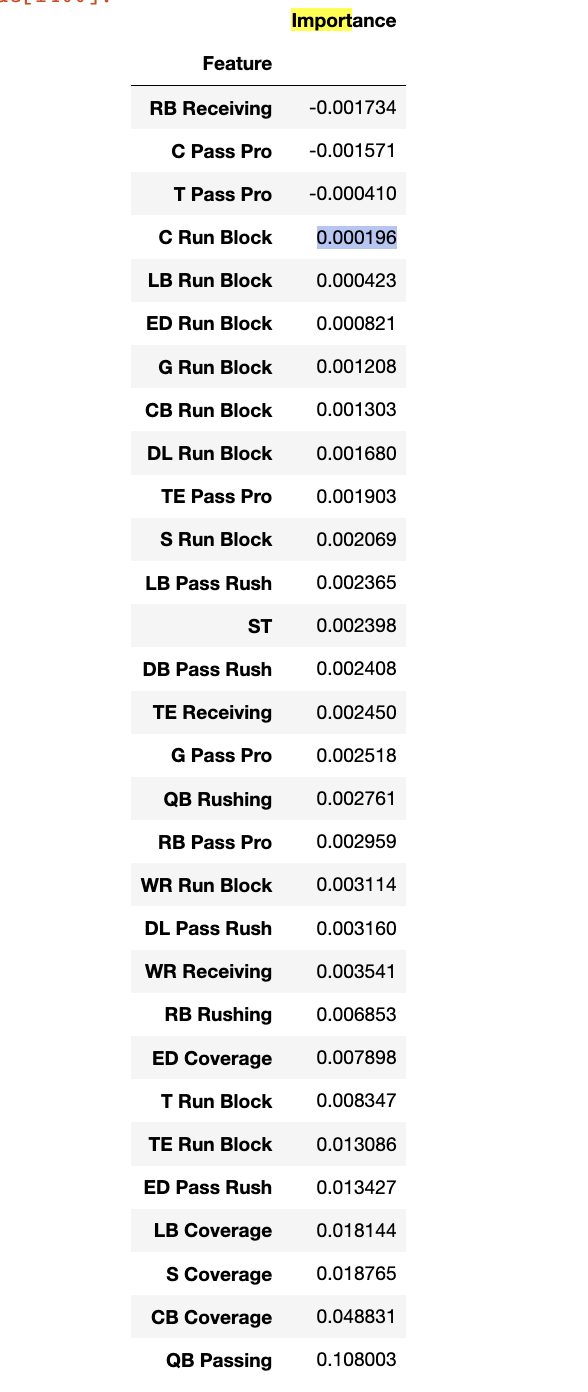

As you can see, clearly Quarterback passing is the most predictive variable for adjusted wins, then coverage by defenders, and edge rushing grade. This agrees with consensus opinion about the importance of the quarterback and the passing game as a whole. 

## 3. Results
After creating and training the random forest model, we can not only see the variable importance of various positional categories, but also make predictions. By modifying one variable while holding the others constant, we can see precisely the effect of that positional category grade on expected wins. My technique was to hold all other variables at 0 - a perfectly average team. I've linked the resulting graphs below, and will explore a sample of interesting results.

https://drive.google.com/drive/folders/1-wYzqd2PUsVp8sJMubHyFwcAwpzDt_dg?usp=sharing

As the model is trained on PFF grades from players who actually played in a game, all analysis should be read with this in mind. An "average" quarterback is really an average quarterback who started.

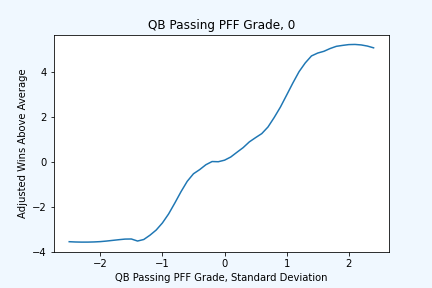
### Adjusted Wins Over Average by Quarterback Passing Grade
The model predicts that a 2.5 standard deviation  quarterback (top 1 QB) is worth almost 5 wins over average over the course of a 17 game season, and that a -2.5 standard deviation quarterback (32nd ranked, or worst quarterback) can instead lose 4 games over an average quarterback. Could the 2022 New York Jets (worst QB passing grade) have had a 11-6 record with a top 1 quarterback last year? That certainly seems to be the bet they've made by acquiring Aaron Rodgers from the Green Bay Packers.

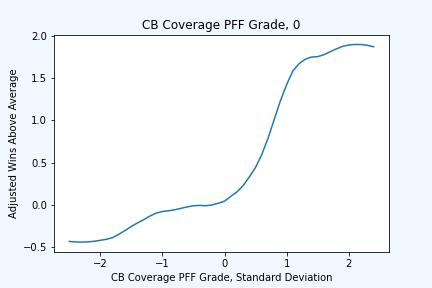
### Adjusted Wins Over Average by Cornerback Coverage Grade
A top cornerback unit can be worth 2 WAA over a season, which certainly seems like a worthy investment, but a below average unit does not seem to lose many more games. 

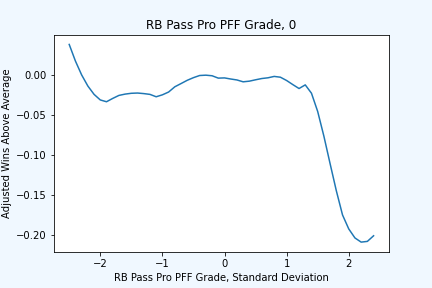

### Adjusted Wins Over Average by Running Back Pass Protection Grade
Where the model may fail. the model predicts that as running back pass protection quality increases, expected wins decrease. One would expect a positive relationship for all factors, but the model is predicting a relatively significant negative relationship here. Could there be explanatory factors? Perhaps. Without complete knowledge of the way PFF grades running back pass protection, it would be hard to say for certain what factors go into the negative correlation. Perhaps higher grades suggest that the quarterback is holding on to the ball longer, which may be detrimental over a season. Focus on RB pass pro may be correlated with less focus on the run game as a whole, leading to lower wins over a season.

### 3.1 Proposing a method to calculate individual player WAA

In this analysis, I used 7 seasons of PFF data to train the model. The first step in an accurate wins above average model would be to use more data, perhaps using individual game data rather than the average over a season, and adding several more seasons worth of PFF data. 

To measure WAA, I propose replacing the player of focus' PFF grades with an average score across a given timeframe (generally, 1 season), and utilizing the model to compute an individual player's total adjusted wins over average for that timeframe. In this way, we have calculated precisely how many wins that player contributes to his team. 

## 4. Conclusions and Reflections
In this analysis I have reaffirmed a number of key consensus points about positional value in football. Quarterback passing was predicted to be a key component in the overall quality of a team. The passing game was shown to be, in general, more important than the run game both offensively and defensively. 

But how might this data be useful to a team? I propose that NFL teams can use this data in contract/salary calculations and negotiations. In graph 2 above, it was shown that an above average cornerback can contribute greatly to added wins. However, lower ranked cornerback units don't lose many more games. Perhaps a conclusion from this would be that overspending for big name cornerbacks is not necessarily a good idea, if money can be focused elsewhere. 

This data might also be useful in NFL draft scouting. Players who play the same position may have wildly different strengths. This data suggests that a linebacker who is very proficient in pass coverage, but weaker in the run game may be more valuable than a linebacker whose strength is run defense. Perhaps Offensive Tackles who are better at run blocking than pass blocking should be given a closer look. 

Of course, I want to discuss some potential limitations of this analysis. First, the sample size is big enough to draw some broad conclusions, but is not big enough to suggest any sort of grand reevaluation of positional value. PFF grades, while trusted by many as a metric of player quality, are not necessarily completely accurate nor independent from other variables - they may have personal bias, may be clouded by overall team quality, and do not include full knowledge of factors such as offensive scheme, coaching decisions, how the play was supposed to be run. 

Ultimately, I believe there are some interesting data to reflect on, to both challenge the approach in this analysis, as well as ones own domain knowledge.